In [1]:
import sys
 
# setting path
sys.path.append('../')

from utils.display import display_pixel_arry

from dcm_anonymizers.img_anonymizers import DCMImageAnonymizer
from dcm_anonymizers.phi_detectors import DcmRobustPHIDetector

from pydicom import dcmread

from pathlib import Path

In [8]:
validation_data_path = "/home/r079a/Desktop/de-identification/dataset/midi-validation-data"
sample_dicom = Path(validation_data_path, 'input_data/4383555268/2.2.167.1.1.2390214.1.351.2355302027984409457/2.2.167.1.1.2390214.1.351.1904357900808398021/00000001.dcm')

# sample_dicom = Path(validation_data_path, 'input_data/2951928526/2.1.846.0.0.0624952.3.426.1171423858789191618/2.1.846.0.0.0624952.3.426.4666769529569841014/00000001.dcm')

print(sample_dicom)

/home/r079a/Desktop/de-identification/dataset/midi-validation-data/input_data/4383555268/2.2.167.1.1.2390214.1.351.2355302027984409457/2.2.167.1.1.2390214.1.351.1904357900808398021/00000001.dcm


In [9]:
dataset = dcmread(sample_dicom)

In [10]:
pixel_data = dataset.get("pixel_array")

In [11]:
print("PixelData" in dataset)

False


In [12]:
print(type(pixel_data))

<class 'NoneType'>


In [6]:
print(pixel_data.shape)

(227, 378, 378)


In [14]:
print(pixel_data[0].shape)

(378, 378)


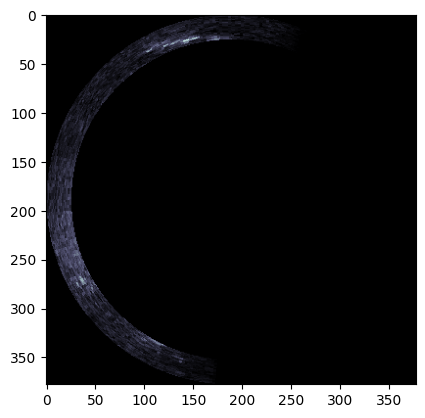

In [15]:
display_pixel_arry(pixel_data[0])

In [ ]:
detector = DcmRobustPHIDetector()

In [ ]:
imganonymizer = DCMImageAnonymizer(phi_detector=detector)

In [ ]:
updated = imganonymizer.anonymize_dicom_image_data(dataset)

In [ ]:
updated